## This is a project which is used to train data sets of photos taken by simulation cars by neural network, and then predict steer angle of the simulation cars

In [1]:
import numpy as np
import pandas as pd
import os
import json
from skimage.exposure import adjust_gamma
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy import ndimage
from scipy.misc import imresize

Using TensorFlow backend.


### First of all, we need to read the driving_log file to read images names, and then get the images from IMG file

In [2]:
angles = pd.read_csv('../driving_log.csv',header=None)
angles.columns = ('Center','Left','Right','Steering Angle','Throttle','Brake','Speed')
angles = np.array(angles['Steering Angle'])

recovery_angles = pd.read_csv('../Recovery/driving_log.csv', header = None)
recovery_angles.columns = ('Center','Left','Right','Steering Angle','Throttle','Brake','Speed')
recovery_angles = np.array(recovery_angles['Steering Angle'])

In [3]:
center_angles=angles
right_angles=angles-0.2
left_angles=angles+0.2
labels=np.concatenate((center_angles,right_angles,left_angles,recovery_angles),axis=0)

In [4]:
len(recovery_angles)

456

In [5]:
images = np.asarray(os.listdir("../IMG/"))
center_images = np.ndarray(shape=(len(center_angles), 32, 64, 3))
right_images = np.ndarray(shape=(len(right_angles), 32, 64, 3))
left_images = np.ndarray(shape=(len(left_angles), 32, 64, 3))

count1 = 0
count2 = 0
count3 = 0
for image in images:
    image_file = os.path.join('../IMG', image)
    if image.startswith('center'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        center_images[count1] = imresize(image_data, (32,64,3))
        count1+=1
    elif image.startswith('right'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        right_images[count2] = imresize(image_data, (32,64,3))
        count2+=1
    elif image.startswith('left'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        left_images[count3] = imresize(image_data, (32,64,3))
        count3 += 1

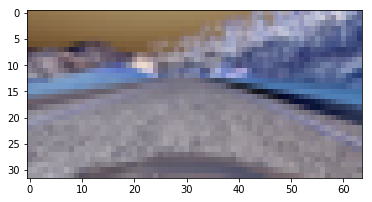

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
plt.imshow(center_images[6])

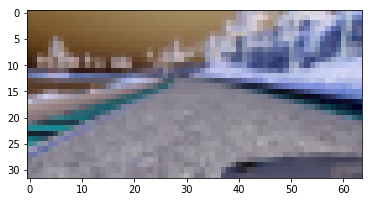

In [7]:
plt.imshow(left_images[0])

In [8]:
#data=np.concatenate((center_images,right_images,left_images),axis=0)
len(labels)

4272

In [9]:
recovery_images = np.asarray(os.listdir("../Recovery/IMG/"))
recovery = np.ndarray(shape=(len(recovery_angles), 32, 64, 3))

# Populate recovery driving dataset
count = 0
for image in recovery_images:
    if image.startswith('center'):
        image_file = os.path.join('../Recovery/IMG', image)
        image_data = ndimage.imread(image_file).astype(np.float32)
        recovery[count] = imresize(image_data, (32,64,3))
        count += 1

In [10]:
data=np.concatenate((center_images,right_images,left_images,recovery),axis=0)

In [11]:
flip_images = np.ndarray(shape=(data.shape))
count = 0
for i in range(len(data)):
    flip_images[count] = np.fliplr(data[i])
    count += 1
flip_images.shape

(4272, 32, 64, 3)

In [12]:
flip_images_angles = labels * -1
training_data = np.concatenate((data, flip_images), axis=0)
training_angles = np.concatenate((labels, flip_images_angles),axis=0)

In [13]:
training_data.shape

(8544, 32, 64, 3)

In [29]:
X_train, X_validation, y_train, y_validation = train_test_split(training_data, training_angles, test_size=.1)

In [30]:
# Establish model architecture
from keras.layers import Cropping2D

model = Sequential()
model.add(Cropping2D(cropping=((10,0), (0,0)), input_shape=(32,64,3)))

model.add(BatchNormalization(axis=1))
model.add(Convolution2D(8,3,3,border_mode='valid',activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(8,3,3,border_mode='valid',activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(16, 3, 3, border_mode='valid', activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(24, 3, 3, border_mode='valid', activation='relu'))
model.add(Dropout(0.3))
model.add(Convolution2D(36, 3, 3, border_mode='valid', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(45, 2, 2, border_mode='valid', activation='relu'))
model.add(Dropout(0.3))
model.add(Convolution2D(45, 2, 2, border_mode='valid', activation='relu'))
model.add(Flatten())

model.add(Dense(560))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_9 (Cropping2D)        (None, 22, 64, 3)     0           cropping2d_input_9[0][0]         
____________________________________________________________________________________________________
batchnormalization_9 (BatchNorma (None, 22, 64, 3)     88          cropping2d_9[0][0]               
____________________________________________________________________________________________________
convolution2d_50 (Convolution2D) (None, 20, 62, 8)     224         batchnormalization_9[0][0]       
____________________________________________________________________________________________________
dropout_40 (Dropout)             (None, 20, 62, 8)     0           convolution2d_50[0][0]           
___________________________________________________________________________________________

In [31]:
adam = Adam(lr=0.0001)
model.compile(loss='mse',optimizer=adam)

In [32]:
checkpoint = ModelCheckpoint(filepath = 'model.h5', verbose = 1, save_best_only=True, monitor='val_loss')

In [33]:
callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

### Now let's train our model

In [35]:
history_object=model.fit(X_train,
        y_train,
        nb_epoch=20,
        verbose=1,
        batch_size=128,
        shuffle=True,
        validation_data=(X_validation, y_validation),
        callbacks=[checkpoint, callback])


json_string = model.to_json()
with open('model.json', 'w') as jsonfile:
    json.dump(json_string, jsonfile)
print("Model Saved")

Train on 7689 samples, validate on 855 samples
Epoch 1/20
7689/7689 [==============================] - 50s - loss: 0.0601 - val_loss: 0.0620
Epoch 2/20
7689/7689 [==============================] - 48s - loss: 0.0525 - val_loss: 0.0597
Epoch 3/20
7689/7689 [==============================] - 47s - loss: 0.0510 - val_loss: 0.0572
Epoch 4/20
7689/7689 [==============================] - 47s - loss: 0.0452 - val_loss: 0.0449
Epoch 5/20
7689/7689 [==============================] - 47s - loss: 0.0393 - val_loss: 0.0442
Epoch 6/20
7689/7689 [==============================] - 47s - loss: 0.0371 - val_loss: 0.0427
Epoch 7/20
7689/7689 [==============================] - 47s - loss: 0.0356 - val_loss: 0.0417
Epoch 8/20
7689/7689 [==============================] - 47s - loss: 0.0349 - val_loss: 0.0421
Epoch 9/20
7689/7689 [==============================] - 47s - loss: 0.0338 - val_loss: 0.0414
Epoch 10/20
7689/7689 [==============================] - 47s - loss: 0.0336 - val_loss: 0.0406
Epoch 11/20


In [36]:
print(history_object.history.keys())

dict_keys(['val_loss', 'loss'])


### Then we can draw a picture to see how loss and val_loss changes over training

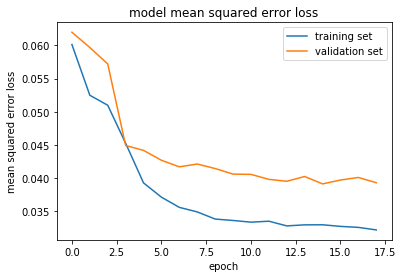

In [37]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [17]:
#here is a VGG network
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model